# Lab 1 _Poisson Regression

Try to use both `SK_learn` and `statmodels` libraries.

A data set of counts has the following characteristics:

1. Whole number data: The data consists of non-negative integers: [0… ∞] Regression techniques such as Ordinary Least Squares Regression may not be appropriate for modeling such data as OLSR works best on real numbers such as -656.0, -0.00000345, 13786.1 etc.
2. Skewed Distribution: The data may contain a large number of data points for just a few values, thereby making the frequency distribution quite skewed. See for example above histogram.
3. Sparsity: The data may reflect the occurrence of a rare event such as a gamma ray burst, thereby making the data sparse.
4. Rate of occurrence: For the sake of creating a model, it can be assumed that there is a certain rate of occurrence of events λ that drives the generation of such data. The event rate may drift over time.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from numpy import exp
from scipy.special import factorial
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.stats import norm


In [2]:
import statsmodels.api as sm
from statsmodels.api import Poisson
from statsmodels.iolib.summary2 import summary_col
from sklearn.linear_model import PoissonRegressor

In [3]:
import random
import math

In [4]:
from patsy import dmatrices

## Time Series Analysis, Regression and Forecasting 

### Example

Here, we use the cleaned data. The raw data are avilable here: https://data.cityofnewyork.us/Transportation/Bicycle-Counters/smn3-rzf9

In [5]:
df = pd.read_csv('nyc_bb_bicyclist_counts.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])
df

,HIGH_T,LOW_T,PRECIP,BB_COUNT
Date,,,,
2017-04-01,46.0,37.0,0.00,606
2017-04-02,62.1,41.0,0.00,2021
2017-04-03,63.0,50.0,0.03,2470
2017-04-04,51.1,46.0,1.18,723
2017-04-05,63.0,46.0,0.00,2807
...,...,...,...,...
2017-10-27,62.1,48.0,0.00,3150
2017-10-28,68.0,55.9,0.00,2245
2017-10-29,64.9,61.0,3.03,183


We’ll add a few derived regression variables to the X matrix.

In [6]:
ds = df.index.to_series()
df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['DAY'] = ds.dt.day

In [7]:
df

,HIGH_T,LOW_T,PRECIP,BB_COUNT,MONTH,DAY_OF_WEEK,DAY
Date,,,,,,,
2017-04-01,46.0,37.0,0.00,606,4,5,1
2017-04-02,62.1,41.0,0.00,2021,4,6,2
2017-04-03,63.0,50.0,0.03,2470,4,0,3
2017-04-04,51.1,46.0,1.18,723,4,1,4
2017-04-05,63.0,46.0,0.00,2807,4,2,5
...,...,...,...,...,...,...,...
2017-10-27,62.1,48.0,0.00,3150,10,4,27
2017-10-28,68.0,55.9,0.00,2245,10,5,28
2017-10-29,64.9,61.0,3.03,183,10,6,29


We will not use the Date variable as a regressor since it contains an absolute date value but we don’t need to do anything special to drop Date as it is already consumed as the index of the pandas DataFrame. So it will not be available to us in the X matrix.

Let’s create the training and testing data sets.

In [8]:
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=178
Testing data set length=36


Setup the regression expression in patsy notation. We are telling patsy that BB_COUNT is our dependent variable and it depends on the regression variables: DAY, DAY_OF_WEEK, MONTH, HIGH_T, LOW_T and PRECIP.

In [9]:
expr = """BB_COUNT ~ DAY  + DAY_OF_WEEK + MONTH + HIGH_T + LOW_T + PRECIP"""

Set up the X and y matrices for the training and testing data sets. patsy makes this really simple.

In [10]:
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

Using the statsmodels GLM class, train the Poisson regression model on the training data set.

In [11]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

Print the training summary.

In [12]:
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               BB_COUNT   No. Observations:                  178
Model:                            GLM   Df Residuals:                      171
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12831.
Date:                Sat, 28 Jan 2023   Deviance:                       23943.
Time:                        22:35:10   Pearson chi2:                 2.34e+04
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.0643      0.012    572.100      

The summary() method on the statsmodels GLMResults class shows a couple of useful goodness-of-fit statistics to help you evaluate whether your Poisson regression model was able to successfully fit the training data. (e.g., Deviance, Pearson Chi2)

The low performance of the model was because the data did not obey the variance = mean criterion required of it by the Poisson regression model. (Negative Binomial model is another choice)

This rather strict criterion is often not satisfied by real world data. Often, the variance is greater than the mean, a property called over-dispersion, and sometimes the variance is less than the mean, called under-dispersion. In such cases, one needs to use a regression model that will not make the equi-dispersion assumption i.e.not assume that variance=mean.

### So how well did our model do? Let’s make some predictions on the test data set.

In [13]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

                   mean    mean_se  mean_ci_lower  mean_ci_upper
Date                                                            
2017-04-09  2732.611633  13.140148    2706.978398    2758.487596
2017-04-19  2086.766220   9.224928    2068.763797    2104.925301
2017-04-29  3116.760899  14.104634    3089.238561    3144.528436
2017-05-02  2543.618419  11.254879    2521.654638    2565.773506
2017-05-03  2319.208193   9.260344    2301.129087    2337.429339
2017-05-06  1955.318526   7.140596    1941.373183    1969.364042
2017-05-14  2631.095380  11.023675    2609.577843    2652.790341
2017-05-15  2684.482691   8.747665    2667.392216    2701.682668
2017-05-17  3911.028368  16.781242    3878.275652    3944.057686
2017-05-25  1346.911288   7.100382    1333.066442    1360.899922
2017-05-30  2093.418197   9.984476    2073.940166    2113.079162
2017-06-07  2674.715760   7.104906    2660.826587    2688.677433
2017-07-01  2485.804272   9.844273    2466.584539    2505.173767
2017-07-09  2747.144331  

Each row: The first column is the date. The second column is the prediciton fo the mean. The third column is the standard error for the mean. The last two columns are teh 95% confidence interval.

Let’s plot the predicted counts versus the actual counts for the test data.

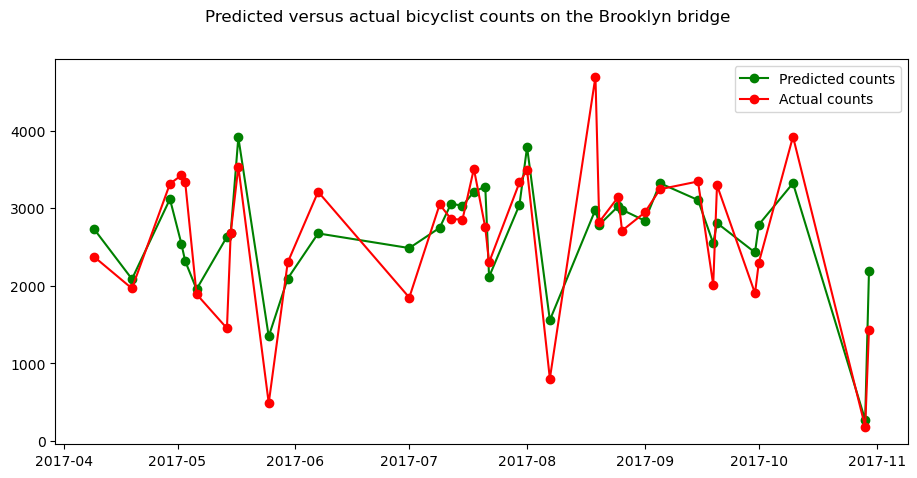

In [14]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['BB_COUNT']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

The model seems to be more or less tracking the trend in the actual counts although in many cases its predictions are way off the actual value.

Let’s also plot Actual versus Predicted counts.

<Figure size 1100x500 with 0 Axes>

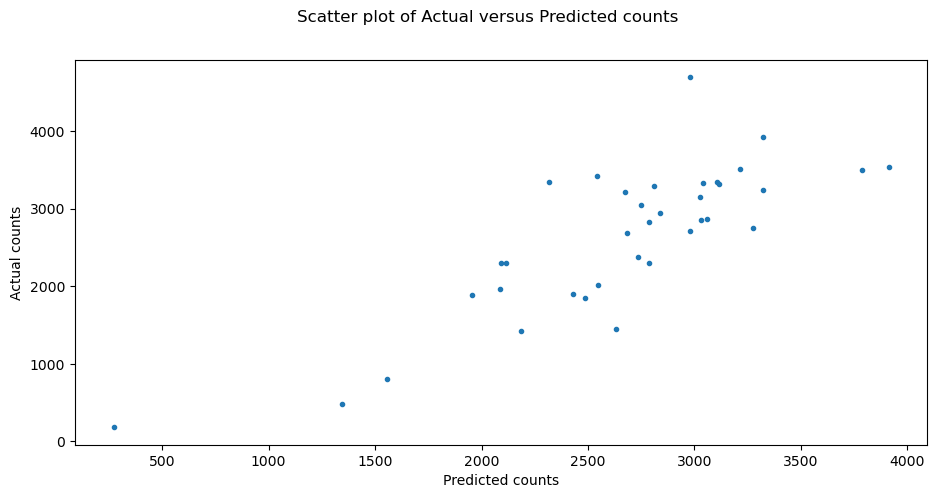

In [15]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

# Traffic Accident Data Set:

Data Sets: 

1. US Accidents (2016 - 2021)

A Countrywide Traffic Accident Dataset (2016 - 2021)

https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents?select=US_Accidents_Dec21_updated.csv  (Data is 1.2G)

Feature information: US-Accidents: A Countrywide Traffic Accident Dataset Description: 
https://smoosavi.org/datasets/us_accidents


2. Accidents in France from 2005 to 2016 (for yourself in future study)

https://www.kaggle.com/datasets/ahmedlahlou/accidents-in-france-from-2005-to-2016 

# Questions:  

#### 1. Use US Accidents (2016 - 2021) data, summerize by daily, use Temperature(F), Precipitation(in), Wind_Speed(mph), humidity (in percentage).  

#### 2. Use Possion regression to model the daily accident in the US (or in one state data, or one city data, or only use 1 year data, if your computer is not powerful enough ) 

#### or 3, You can also summerize your own question, but you need to use possion regression to model the data

Kaggle has several good notebooks in python: 
For example, https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents/code?select=US_Accidents_Dec21_updated.csv and find in `Code`

One example for Cleveland, OH.
https://www.kaggle.com/code/sekoukeita/analysis-and-visualization-for-us-and-cleveland-oh


#### or 4. If you feel difficult of dealing with the raw data above, you can start with a similar example from below:
Daily total of bike counts conducted monthly on the Brooklyn Bridge, Manhattan Bridge, Williamsburg Bridge, and Queensboro Bridge.
https://data.cityofnewyork.us/Transportation/Bicycle-Counts-for-East-River-Bridges-Historical-/gua4-p9wg 